
Scenario 1 – Light Day (Poya)
Vehicles Served: 15
Average Waiting Time: 3.27 mins
Throughput: 2.50 vehicles/hour
Advisor Utilization: 2.1%
Technician Utilization: 0.7%

Scenario 2 – Normal Day
Vehicles Served: 27
Average Waiting Time: 62.40 mins
Throughput: 3.38 vehicles/hour
Advisor Utilization: 2.8%
Technician Utilization: 0.9%

Scenario 3 – Busy Day
Vehicles Served: 44
Average Waiting Time: 69.82 mins
Throughput: 5.50 vehicles/hour
Advisor Utilization: 3.1%
Technician Utilization: 1.3%

Summary Table:
                        Scenario  Vehicles Served  Average Wait (mins)  \
0  Scenario 1 – Light Day (Poya)               15                 3.27   
1        Scenario 2 – Normal Day               27                62.40   
2          Scenario 3 – Busy Day               44                69.82   

   Throughput (veh/hour)  Advisor Util (%)  Technician Util (%)  
0                   2.50               2.1                  0.7  
1                   3.38               2.8                  

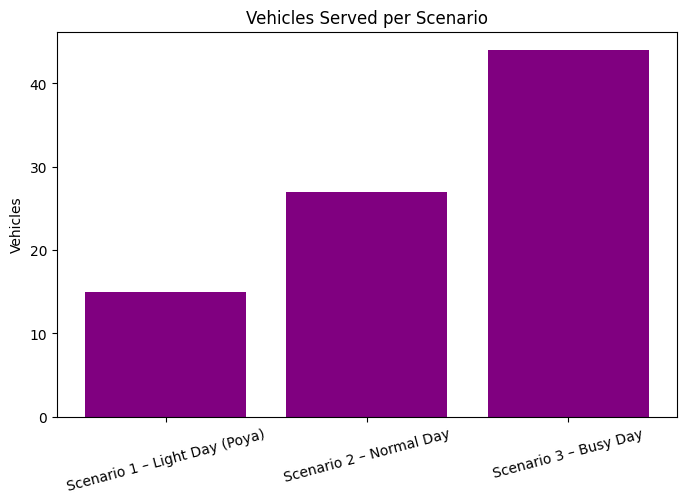

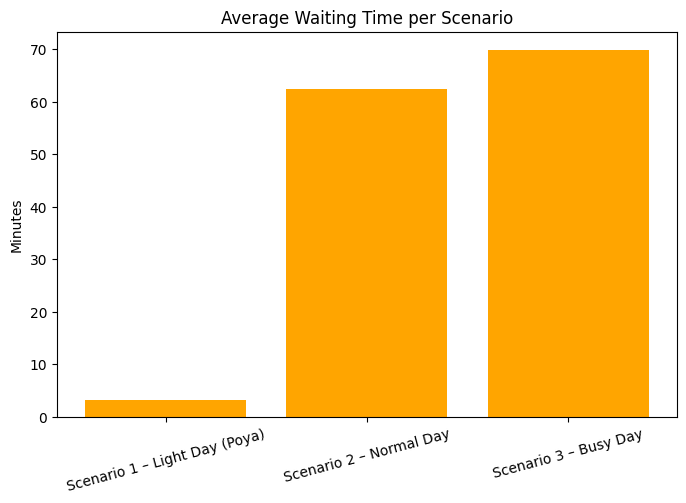

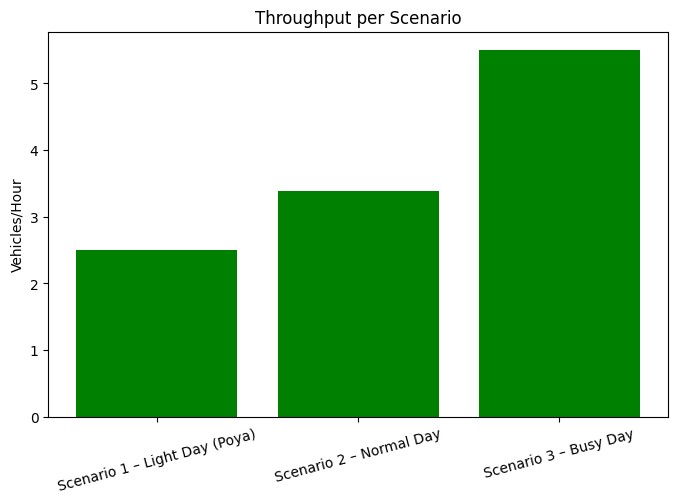

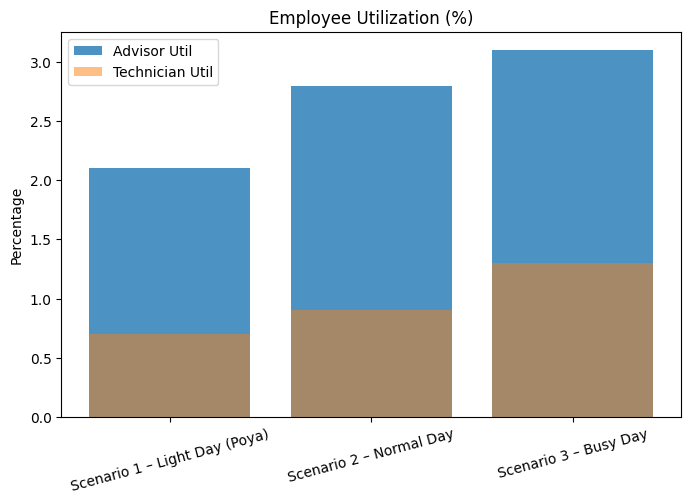

In [2]:
import simpy
import random
import statistics
import matplotlib.pyplot as plt
import pandas as pd

# Fixed random seed for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# -----------------------------
# Vehicle Service Station
# -----------------------------
class ServiceStation:
    def __init__(self, env, num_advisors, num_technicians):
        self.env = env
        self.advisors = simpy.Resource(env, num_advisors)
        self.technicians = simpy.Resource(env, num_technicians)
        self.wait_times = []
        self.vehicles_served = 0

    def service_vehicle(self, vehicle_type):
        durations = {'bike': (10, 20), 'car': (20, 35), 'van': (30, 45), 'bus': (40, 60)}
        duration = random.uniform(*durations[vehicle_type])
        yield self.env.timeout(duration)
        self.vehicles_served += 1

# -----------------------------
# Vehicle Arrival Process
# -----------------------------
def vehicle_arrivals(env, station, interarrival):
    vehicle_types = ['bike', 'car', 'van', 'bus']
    while True:
        yield env.timeout(random.expovariate(1.0 / interarrival))
        vehicle_type = random.choice(vehicle_types)
        env.process(handle_vehicle(env, station, vehicle_type))

# -----------------------------
# Handle each vehicle
# -----------------------------
def handle_vehicle(env, station, vehicle_type):
    arrival_time = env.now
    with station.advisors.request() as adv_req:
        yield adv_req
        with station.technicians.request() as tech_req:
            yield tech_req
            wait = env.now - arrival_time
            station.wait_times.append(wait)
            yield env.process(station.service_vehicle(vehicle_type))

# -----------------------------
# Run a single scenario
# -----------------------------
def run_scenario(name, num_advisors, num_technicians, interarrival, sim_time):
    env = simpy.Environment()
    station = ServiceStation(env, num_advisors, num_technicians)
    env.process(vehicle_arrivals(env, station, interarrival))
    env.run(until=sim_time)

    avg_wait = statistics.mean(station.wait_times) if station.wait_times else 0
    throughput = station.vehicles_served / (sim_time / 60)  # vehicles per hour
    advisor_util = (station.vehicles_served / (num_advisors * sim_time)) * 100
    tech_util = (station.vehicles_served / (num_technicians * sim_time)) * 100

    print(f"\n{name}")
    print(f"Vehicles Served: {station.vehicles_served}")
    print(f"Average Waiting Time: {avg_wait:.2f} mins")
    print(f"Throughput: {throughput:.2f} vehicles/hour")
    print(f"Advisor Utilization: {advisor_util:.1f}%")
    print(f"Technician Utilization: {tech_util:.1f}%")

    return {
        "Scenario": name,
        "Vehicles Served": station.vehicles_served,
        "Average Wait (mins)": round(avg_wait,2),
        "Throughput (veh/hour)": round(throughput,2),
        "Advisor Util (%)": round(advisor_util,1),
        "Technician Util (%)": round(tech_util,1)
    }

# -----------------------------
# Define Scenarios
# -----------------------------
scenarios = [
    ("Scenario 1 – Light Day (Poya)", 2, 6, 25, 360),
    ("Scenario 2 – Normal Day", 2, 6, 15, 480),
    ("Scenario 3 – Busy Day", 3, 7, 8, 480)
]

results = []
for sc in scenarios:
    results.append(run_scenario(*sc))

# -----------------------------
# Visualization
# -----------------------------
df = pd.DataFrame(results)
print("\nSummary Table:")
print(df)

plt.figure(figsize=(8,5))
plt.bar(df["Scenario"], df["Vehicles Served"], color='purple')
plt.title("Vehicles Served per Scenario")
plt.ylabel("Vehicles")
plt.xticks(rotation=15)
plt.show()

plt.figure(figsize=(8,5))
plt.bar(df["Scenario"], df["Average Wait (mins)"], color='orange')
plt.title("Average Waiting Time per Scenario")
plt.ylabel("Minutes")
plt.xticks(rotation=15)
plt.show()

plt.figure(figsize=(8,5))
plt.bar(df["Scenario"], df["Throughput (veh/hour)"], color='green')
plt.title("Throughput per Scenario")
plt.ylabel("Vehicles/Hour")
plt.xticks(rotation=15)
plt.show()

plt.figure(figsize=(8,5))
plt.bar(df["Scenario"], df["Advisor Util (%)"], alpha=0.8, label="Advisor Util")
plt.bar(df["Scenario"], df["Technician Util (%)"], alpha=0.5, label="Technician Util")
plt.title("Employee Utilization (%)")
plt.ylabel("Percentage")
plt.xticks(rotation=15)
plt.legend()
plt.show()